## 🩺 Classificação de Câncer de Pele utilizando CNN
Este notebook realiza o treinamento, avaliação e visualização com Grad-CAM de um modelo baseado em **MobileNetV2** para classificação de imagens dermatológicas.

Todas as seções estão nomeadas em português para facilitar a compreensão do fluxo de trabalho.

### 📦 Importação das Bibliotecas

In [1]:
# ------------------------------------------------------------------
# Instalação de bibliotecas necessárias
# ------------------------------------------------------------------
# Descomente a linha abaixo se não tiver as bibliotecas instaladas
# pip install pandas numpy matplotlib seaborn scikit-learn tensorflow shap opencv-python pillow tqdm nbformat

In [ ]:
# ------------------------------------------------------------------
# Realizando os Imports
# ------------------------------------------------------------------
import os
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2, MobileNetV3Small
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import cv2
import warnings
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import textwrap

warnings.filterwarnings("ignore", category=UserWarning, module="keras.src.trainers.data_adapters.py_dataset_adapter")
np.random.seed(42)

# print('Imports carregados')

### 📂 Carregamento e Preparação dos Dados

In [3]:
# ------------------------------------------------------------------
# Download do dataset
# ------------------------------------------------------------------

def baixar_dataset(base_dir_name='farjanakabirsamanta/skin-cancer-dataset'):
    home = Path.home()
    cache_base = home / '.cache' / 'kagglehub' / 'datasets'
    if cache_base.exists():
        candidates = list(cache_base.glob(f'**/{base_dir_name}'))
        if not candidates:
            candidates = list(cache_base.glob('**/skin-cancer-dataset'))
        if candidates:
            candidates.sort(key=lambda p: (str(p).count(os.sep), p.name), reverse=True)
            return Path(candidates[0])
    cwd = Path.cwd()
    csvs = list(cwd.glob('**/HAM10000_metadata.csv'))
    if csvs:
        return csvs[0].parent
    raise FileNotFoundError('Dataset HAM10000 não encontrado.')

dataset_base = baixar_dataset()

In [4]:
# ------------------------------------------------------------------
# Carregando os metadados
# ------------------------------------------------------------------
metadata_path = list(dataset_base.glob('**/HAM10000_metadata.csv'))[0]
metadata = pd.read_csv(metadata_path)

# ------------------------------------------------------------------
# Ajustando as colunas e localizando a pasta de imagens
# ------------------------------------------------------------------
mapping = {
    'akiec': 'Queratose actínica',
    'bcc': 'Carcinoma basocelular',
    'bkl': 'Lesão benigna tipo queratose',
    'df': 'Dermatofibroma',
    'mel': 'Melanoma',
    'nv': 'Nevo melanocítico', 
    'vasc': 'Lesão vascular'
}
metadata['diagnosis'] = metadata['dx'].map(mapping)

column_rename_map = {
    'lesion_id': 'id_lesao',
    'image_id': 'image_id',
    'dx': 'codigo_diagnostico',
    'dx_type': 'tipo_diagnostico',
    'age': 'idade',
    'sex': 'sexo',
    'localization': 'localizacao',
    'diagnosis': 'diagnostico',
    'image_path': 'image_path'
}
metadata = metadata.rename(columns=column_rename_map)

image_folders = [p for p in dataset_base.glob('**/*') if p.is_dir()]
best = None
best_count = 0
for p in image_folders:
    count = len(list(p.glob('*.jpg')))
    if count > best_count:
        best = p
        best_count = count
if best is None or best_count == 0:
    raise FileNotFoundError('Pasta de imagens não encontrada no dataset base: ' + str(dataset_base))
images_root = best

def resolve_image_path(image_id, images_root):
    for ext in ('.jpg', '.jpeg', '.png'):
        candidate = images_root / f"{image_id}{ext}"
        if candidate.exists():
            return str(candidate)
    found = list(images_root.rglob(f"{image_id}.*"))
    return str(found[0]) if found else None

metadata['image_path'] = metadata['image_id'].apply(lambda x: resolve_image_path(x, images_root))
metadata = metadata[metadata['image_path'].notnull()].reset_index(drop=True)

sexo_mapping = {
    'male': 'masculino',
    'female': 'feminino',
    'unknown': 'desconhecido'
}

metadata['sexo'] = metadata['sexo'].replace(sexo_mapping)

tipo_mapping = {
    "histo": "Biópsia / Exame de tecido",
    "consensus": "Diagnóstico por consenso médico",
    "confocal": "Imagem confocal",
    "follow_up": "Acompanhamento clínico"
}

metadata['tipo_diagnostico'] = metadata['tipo_diagnostico'].replace(tipo_mapping)

print('Registros carregados:', len(metadata))
metadata.info()

Registros carregados: 10015
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id_lesao            10015 non-null  object 
 1   image_id            10015 non-null  object 
 2   codigo_diagnostico  10015 non-null  object 
 3   tipo_diagnostico    10015 non-null  object 
 4   idade               9958 non-null   float64
 5   sexo                10015 non-null  object 
 6   localizacao         10015 non-null  object 
 7   diagnostico         10015 non-null  object 
 8   image_path          10015 non-null  object 
dtypes: float64(1), object(8)
memory usage: 704.3+ KB


### 🔍 Análise Exploratória

Contagem por classe de diagnóstico:


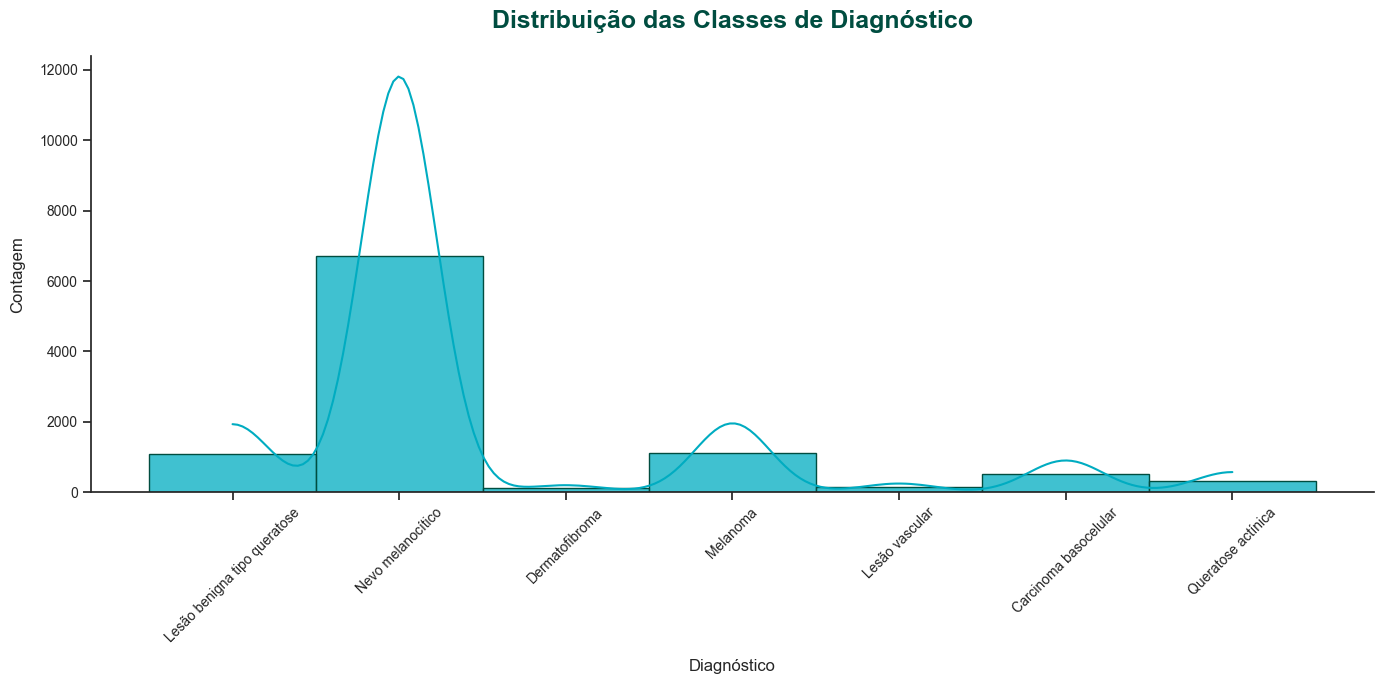


Amostras visuais por classe de diagnóstico:


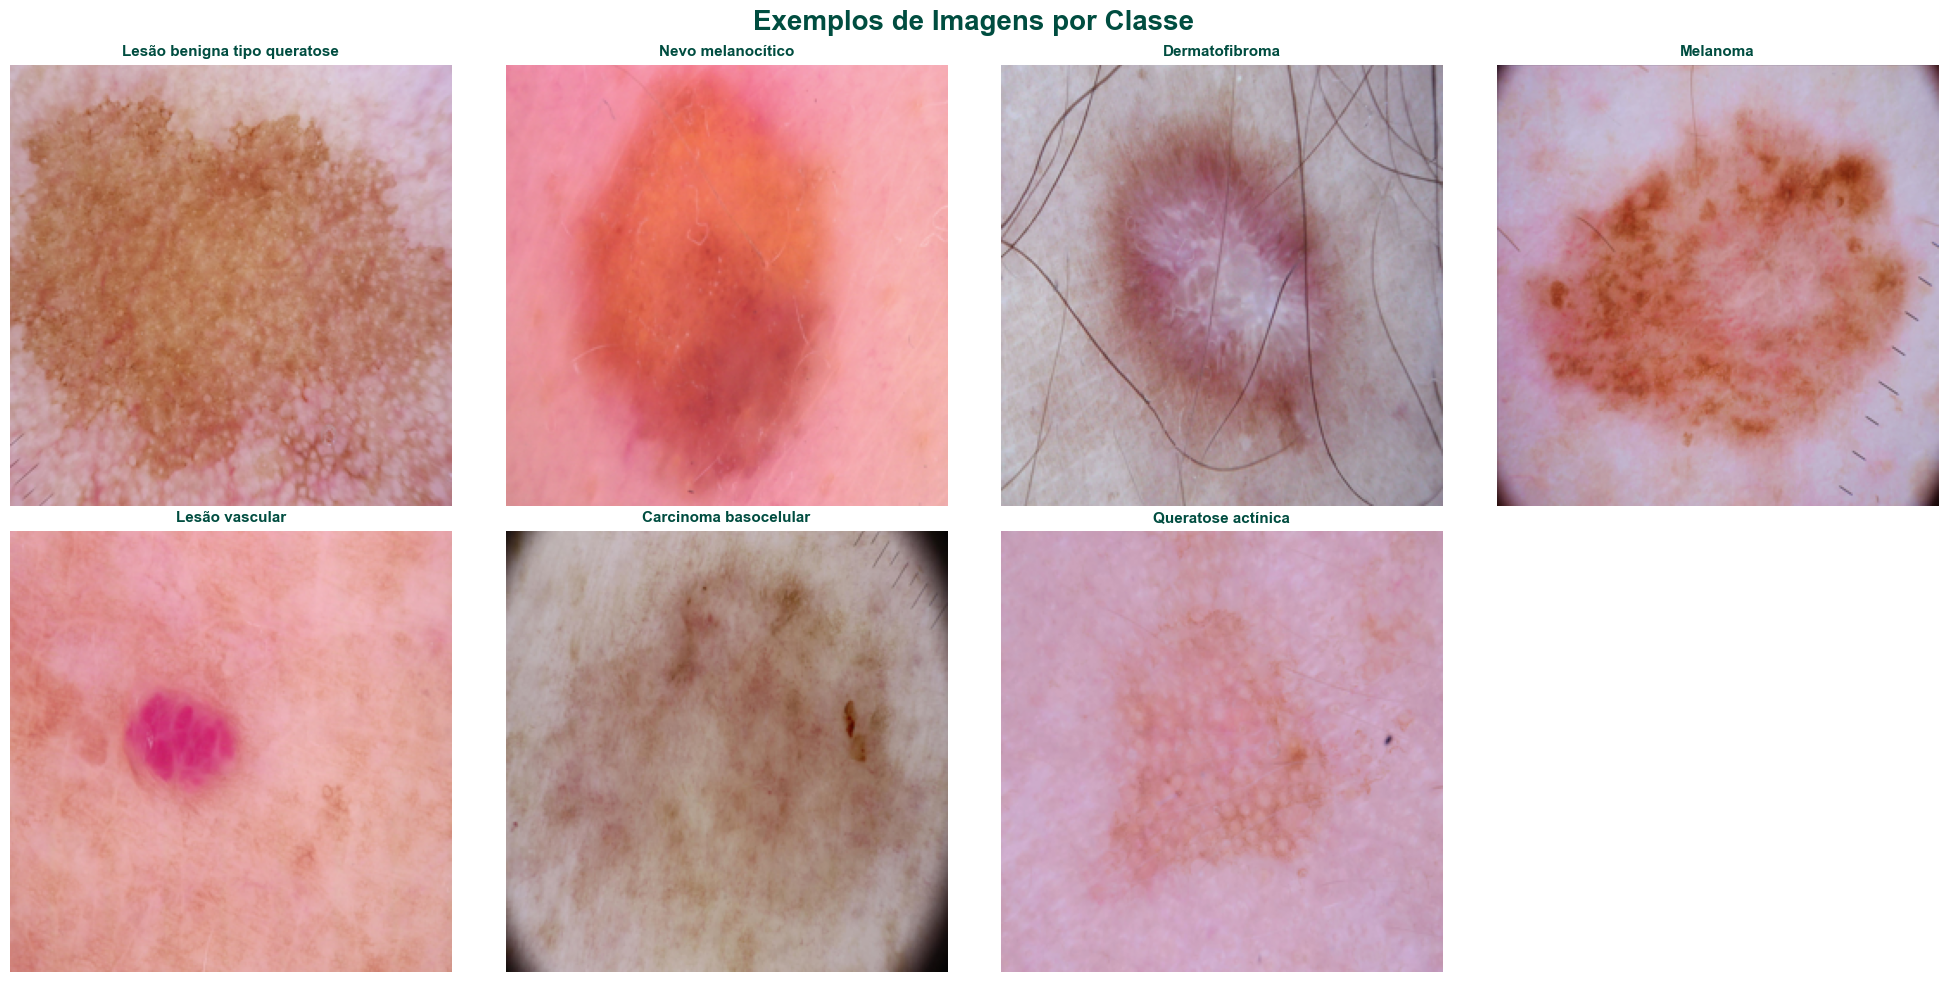

In [5]:
# ------------------------------------------------------------------
# Definição de estilo para os gráficos
# ------------------------------------------------------------------
sns.set_theme(
    style="ticks",
    context="notebook",
    palette="pastel"
)

# ------------------------------------------------------------------
# Distribuição das Classes
# ------------------------------------------------------------------
plt.figure(figsize=(14, 7))

sns.histplot(
    data=metadata,
    x='diagnostico',
    kde=True,
    bins=len(metadata['diagnostico'].unique()),
    color="#00ACC1",
    edgecolor="#004D40",
    alpha=0.75
)

print("Contagem por classe de diagnóstico:")

plt.title("Distribuição das Classes de Diagnóstico", fontsize=18, weight='bold', pad=20, color="#004D40")
plt.xlabel("Diagnóstico", fontsize=12, labelpad=10)
plt.ylabel("Contagem", fontsize=12, labelpad=10)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
sns.despine()
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# Amostras Visuais
# ------------------------------------------------------------------
print("\nAmostras visuais por classe de diagnóstico:")

unique_labels = metadata['diagnostico'].unique()
cols = 4
rows = (len(unique_labels) + cols - 1) // cols

plt.figure(figsize=(5*cols, 5*rows))
for i, label in enumerate(unique_labels):
    subset = metadata[metadata['diagnostico'] == label]
    if subset.empty:
        continue
    sample_row = subset.sample(1, random_state=42).iloc[0]
    img = Image.open(sample_row['image_path']).convert('RGB')
    plt.subplot(rows, cols, i+1)
    plt.imshow(img.resize((256,256)))
    plt.title(label, fontsize=11, color="#004D40", weight='semibold')
    plt.axis('off')

plt.suptitle("Exemplos de Imagens por Classe", fontsize=20, weight='bold', color="#004D40", y=0.98)
plt.tight_layout()
plt.show()

In [6]:
print("Campo \"Diagnóstico\"")
metadata['diagnostico'].describe().astype(str)

Campo "Diagnóstico"


count                 10015
unique                    7
top       Nevo melanocítico
freq                   6705
Name: diagnostico, dtype: object

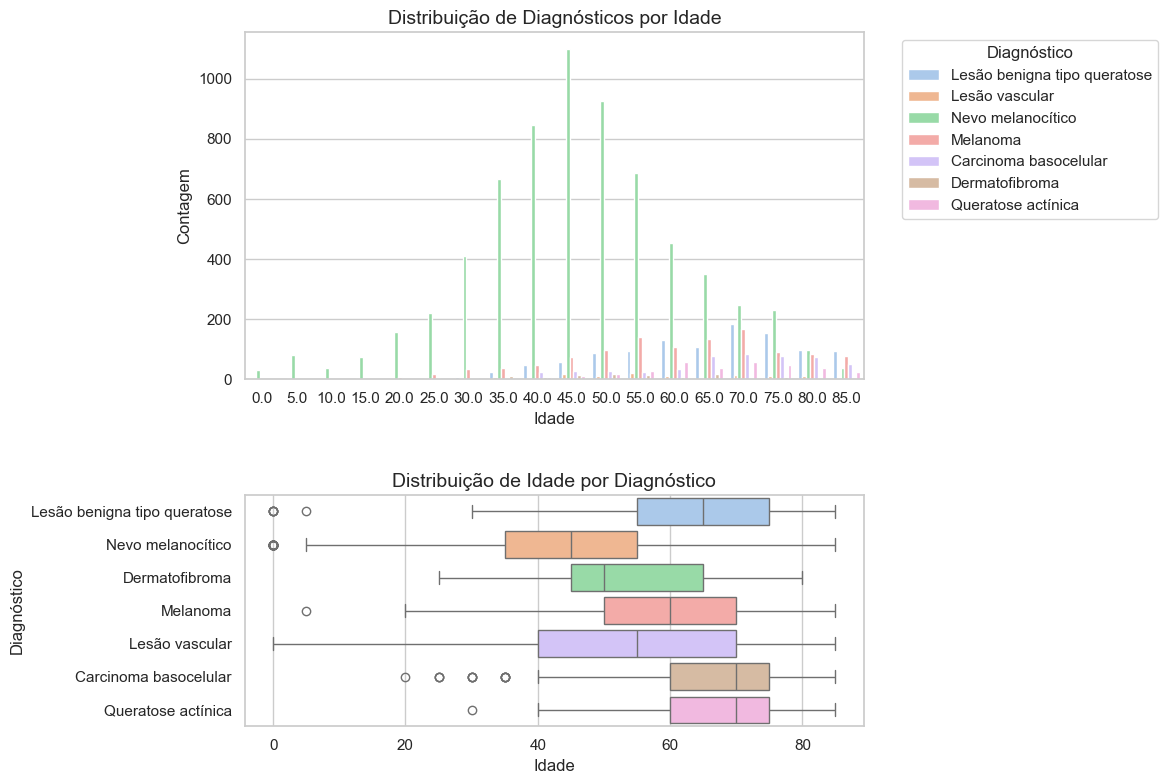

In [7]:
# ------------------------------------------------------------------
# Configurando Estilo e Paleta de cores
# ------------------------------------------------------------------
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)
unique_diag = sorted(metadata['diagnostico'].unique())
palette_diag = sns.color_palette("pastel", len(unique_diag))

# ------------------------------------------------------------------
# Criação dos subplots: histograma e boxplot
# ------------------------------------------------------------------
fig, axes = plt.subplots(
    nrows=2,
    ncols=1,
    gridspec_kw={'height_ratios': [1.5, 1]},
    sharex=False
)

ax_hist, ax_box = axes

# ------------------------------------------------------------------
# Histograma: contagem de diagnósticos por idade
# ------------------------------------------------------------------
hist_obj = sns.countplot(
    data=metadata,
    x='idade',
    hue='diagnostico',
    palette=palette_diag,
    ax=ax_hist
)

ax_hist.set_title('Distribuição de Diagnósticos por Idade', fontsize=14)
ax_hist.set_xlabel('Idade')
ax_hist.set_ylabel('Contagem')
hist_handles, hist_labels = hist_obj.get_legend_handles_labels()

ax_hist.legend(
    title='Diagnóstico',
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)

# ------------------------------------------------------------------
# Boxplot – distribuição de idade por diagnóstico (sem warning)
# ------------------------------------------------------------------
box_obj = sns.boxplot(
    data=metadata,
    x='idade',
    y='diagnostico',
    hue='diagnostico',        
    palette=palette_diag,
    legend=False,             
    ax=ax_box
)

if ax_box.get_legend() is not None:
    ax_box.get_legend().remove()

ax_box.set_title('Distribuição de Idade por Diagnóstico', fontsize=14)
ax_box.set_xlabel('Idade')
ax_box.set_ylabel('Diagnóstico')

# ------------------------------------------------------------------
# Exibição dos gráficos
# ------------------------------------------------------------------
plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()

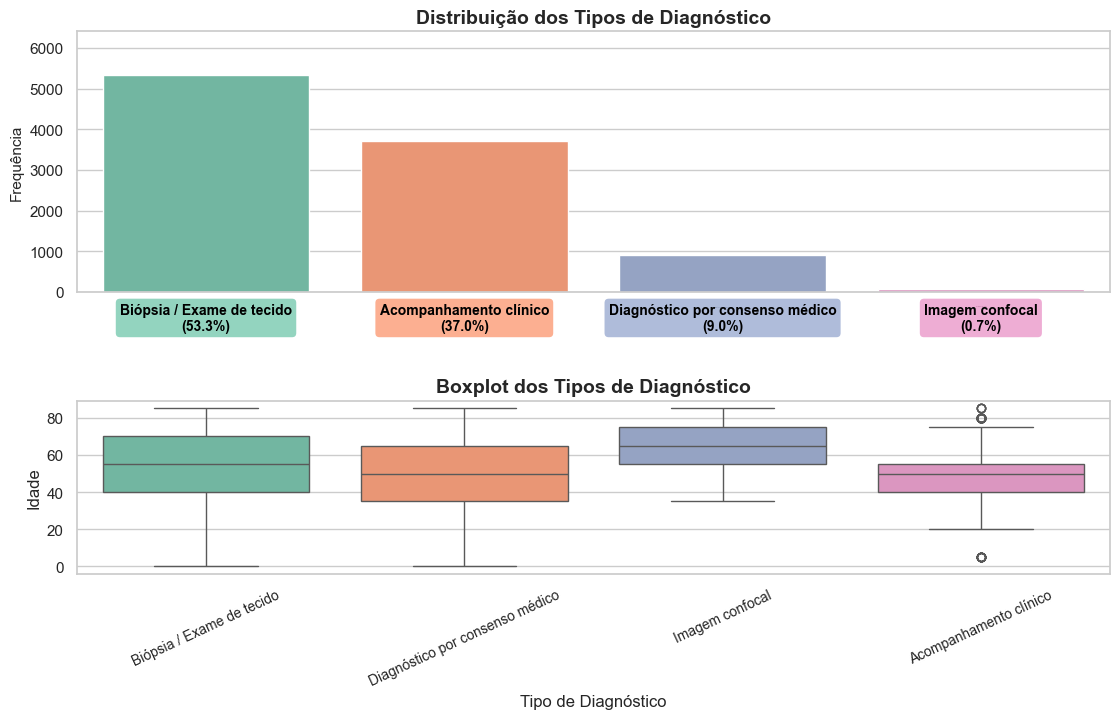

In [8]:
# ------------------------------------------------------------------
# Ajustando os dados para os gráficos
# ------------------------------------------------------------------
contagem = metadata["tipo_diagnostico"].value_counts()
porcentagem = (contagem / contagem.sum()) * 100

dados_plot = pd.DataFrame({
    "Tipo de Diagnóstico": contagem.index,
    "Frequência": contagem.values,
    "Porcentagem": porcentagem.values
})

# ------------------------------------------------------------------
# Configurando as Cores
# ------------------------------------------------------------------
cores = sns.color_palette("Set2", len(dados_plot))

# ------------------------------------------------------------------
# Ajustando os gráficos
# ------------------------------------------------------------------
fig, axes = plt.subplots(
    nrows=2, ncols=1,
    figsize=(12, 8),
    gridspec_kw={'height_ratios': [3, 2]}
)

sns.barplot(
    data=dados_plot,
    x="Tipo de Diagnóstico",
    y="Frequência",
    hue="Tipo de Diagnóstico",  
    palette=cores,
    legend=False,
    ax=axes[0]
)

axes[0].set_title("Distribuição dos Tipos de Diagnóstico", fontsize=14, weight='bold')
axes[0].set_xlabel("")
axes[0].set_ylabel("Frequência", fontsize=11)
axes[0].tick_params(axis='x', labelsize=0) 

for i, (label, cor, pct) in enumerate(zip(dados_plot["Tipo de Diagnóstico"], cores, dados_plot["Porcentagem"])):
    axes[0].text(
        i, -max(dados_plot["Frequência"]) * 0.05, 
        f"{label}\n({pct:.1f}%)",
        color="black",
        fontsize=10,
        ha="center",
        va="top",
        weight="bold",
        bbox=dict(facecolor=cor, alpha=0.7, boxstyle="round,pad=0.3", edgecolor="none")
    )

axes[0].set_ylim(0, max(dados_plot["Frequência"]) * 1.2)

sns.boxplot(
    data=metadata,
    x="tipo_diagnostico",
    y="idade",
    hue="tipo_diagnostico",
    palette=cores,
    legend=False,
    ax=axes[1]
)

axes[1].set_title("Boxplot dos Tipos de Diagnóstico", fontsize=14, weight='bold')
axes[1].set_xlabel("Tipo de Diagnóstico", fontsize=12)
axes[1].set_ylabel("Idade")
axes[1].tick_params(axis='x', labelrotation=25, labelsize=10)

# ------------------------------------------------------------------
# Ajustes Finais
# ------------------------------------------------------------------
plt.tight_layout(pad=3)
plt.subplots_adjust(hspace=0.5)
plt.show()

In [9]:
metadata.describe()

idade
count  9958.000000
mean     51.863828
std      16.968614
min       0.000000
25%      40.000000
50%      50.000000
75%      65.000000
max      85.000000

### 🧠 Treinamento do modelo

In [10]:
# ------------------------------------------------------------------
# Treinando o Modelo
# ------------------------------------------------------------------
le = LabelEncoder()
metadata['label'] = le.fit_transform(metadata['diagnostico'])
train_df, temp_df = train_test_split(metadata, stratify=metadata['label'], test_size=0.25, random_state=42)
val_df, test_df = train_test_split(temp_df, stratify=temp_df['label'], test_size=0.5, random_state=42)

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.1, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(train_df, x_col='image_path', y_col='diagnostico', target_size=IMG_SIZE, class_mode='categorical', batch_size=BATCH_SIZE)
val_gen = val_datagen.flow_from_dataframe(val_df, x_col='image_path', y_col='diagnostico', target_size=IMG_SIZE, class_mode='categorical', batch_size=BATCH_SIZE)
test_gen = val_datagen.flow_from_dataframe(test_df, x_col='image_path', y_col='diagnostico', target_size=IMG_SIZE, class_mode='categorical', batch_size=BATCH_SIZE, shuffle=False)

Found 7511 validated image filenames belonging to 7 classes.
Found 1252 validated image filenames belonging to 7 classes.
Found 1252 validated image filenames belonging to 7 classes.


In [11]:
# ------------------------------------------------------------------
# Executando o MobileNetV2
# ------------------------------------------------------------------
base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
for layer in base.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base.output)
x = Dropout(0.3)(x)
num_classes = len(train_gen.class_indices)
outputs = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base.input, outputs=outputs)
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
#model.summary()

In [ ]:
# ------------------------------------------------------------------
# Treinamento dos EPOCHS
# ------------------------------------------------------------------

classes = list(train_gen.class_indices.keys())
val_counts = pd.Series(val_gen.classes).value_counts().reindex(range(len(classes)), fill_value=0)
val_counts.index = classes
print("Distribuição das classes no conjunto de validação:\n")
print(val_counts)

# ------------------------------------------------------------------
# Calculando peso das classes
# ------------------------------------------------------------------
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)

# ------------------------------------------------------------------
# Convertendo pesos para dicionário do KERAS
# ------------------------------------------------------------------
class_weights = dict(enumerate(class_weights))
print("\nPesos de classe calculados:", class_weights)

# ------------------------------------------------------------------
# Treinamento do Modelo
# ------------------------------------------------------------------
EPOCHS = 12
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    class_weight=class_weights,
    verbose=1
)

Distribuição das classes no conjunto de validação:

Carcinoma basocelular            64
Dermatofibroma                   15
Lesão benigna tipo queratose    137
Lesão vascular                   18
Melanoma                        139
Nevo melanocítico               838
Queratose actínica               41
Name: count, dtype: int64

Pesos de classe calculados: {0: np.float64(2.787012987012987), 1: np.float64(12.476744186046512), 2: np.float64(1.3021844660194175), 3: np.float64(10.02803738317757), 4: np.float64(1.2850299401197605), 5: np.float64(0.21336249751441638), 6: np.float64(4.3795918367346935)}
Epoch 1/12
 59/235 ━━━━━━━━━━━━━━━━━━━━ 1:17 438ms/step - accuracy: 0.2966 - loss: 2.3409

KeyboardInterrupt: 

: 

### 📖 Avaliação

40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step
                              precision    recall  f1-score   support

       Carcinoma basocelular       0.39      0.57      0.47        65
              Dermatofibroma       0.04      0.14      0.06        14
Lesão benigna tipo queratose       0.33      0.46      0.39       138
              Lesão vascular       0.38      0.82      0.52        17
                    Melanoma       0.33      0.58      0.42       139
           Nevo melanocítico       0.92      0.66      0.77       838
          Queratose actínica       0.31      0.27      0.29        41

                    accuracy                           0.61      1252
                   macro avg       0.39      0.50      0.42      1252
                weighted avg       0.73      0.61      0.65      1252



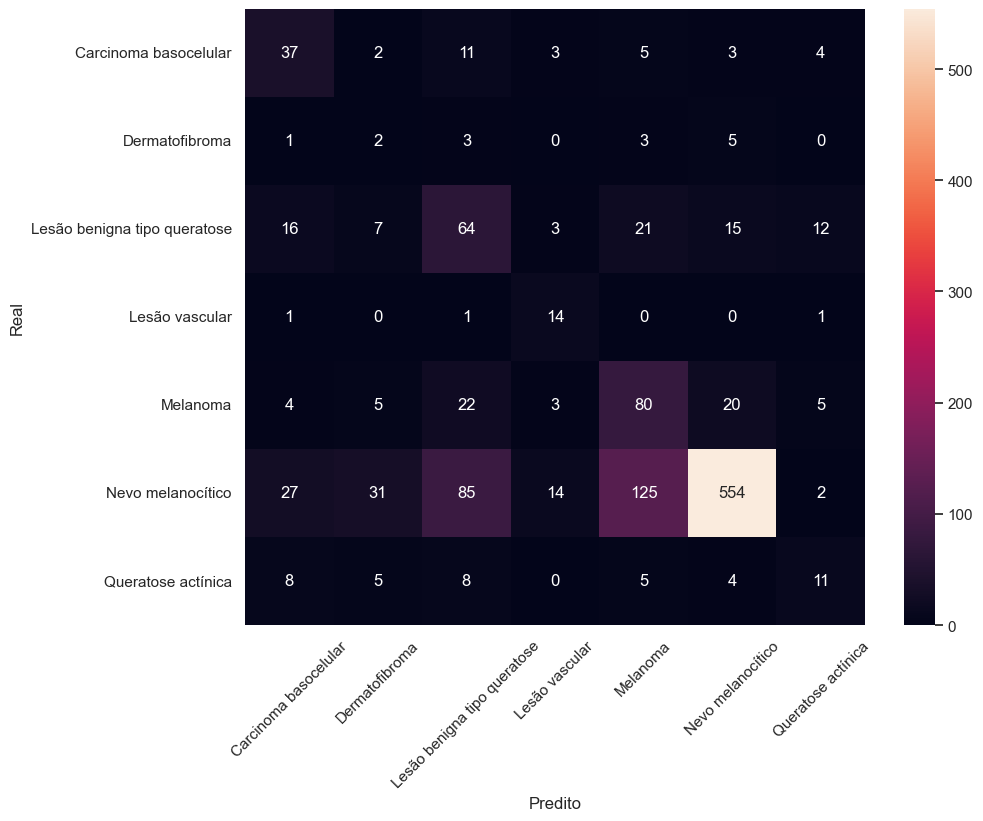

In [ ]:
# ------------------------------------------------------------------
# Realizando a avaliação e extraindo matriz de confusão
# ------------------------------------------------------------------
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
y_true = test_gen.classes

print(classification_report(
    y_true, 
    y_pred, 
    target_names=list(train_gen.class_indices.keys()),
    zero_division=0
))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
ax = sns.heatmap(cm, annot=True, fmt='d', xticklabels=list(train_gen.class_indices.keys()), yticklabels=list(train_gen.class_indices.keys()))
ax.set_xlabel('Predito')
ax.set_ylabel('Real')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

### 🔥 Funções Grad-CAM

In [ ]:
# ------------------------------------------------------------------
# Extraindo Mapa de Grad-CAM
# ------------------------------------------------------------------
def encontrar_ultima_conv(model):
    ultima_conv = None

    def procurar_camadas(m):
        nonlocal ultima_conv
        for layer in m.layers:
            if hasattr(layer, 'layers') and len(layer.layers) > 0:
                procurar_camadas(layer)
            if isinstance(layer, (tf.keras.layers.Conv2D,
                                  tf.keras.layers.DepthwiseConv2D,
                                  tf.keras.layers.SeparableConv2D)):
                ultima_conv = layer.name

    procurar_camadas(model)
    return ultima_conv

ultima_conv = encontrar_ultima_conv(model)
print("Última camada convolucional encontrada:", ultima_conv)

def gerar_gradcam_heatmap(model, img_array, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(model.input, [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))

    conv_outputs = conv_outputs[0].numpy()
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:,:,i] *= pooled_grads[i]
    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= (heatmap.max() + 1e-8)
    heatmap = cv2.resize(heatmap, (IMG_SIZE[1], IMG_SIZE[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    return heatmap

def gerar_mapa_gradcam(model, imagem_array, nome_camada_conv):
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[model.get_layer(nome_camada_conv).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(imagem_array)
        classe_pred = tf.argmax(pred[0])
        loss = pred[:, classe_pred]

    grads = tape.gradient(loss, conv_output)[0]
    pesos = tf.reduce_mean(grads, axis=(0,1))
    gradcam = tf.reduce_sum(tf.multiply(pesos, conv_output[0]), axis=-1)

    heatmap = np.maximum(gradcam, 0) / (tf.reduce_max(gradcam) + 1e-8)
    heatmap = cv2.resize(heatmap.numpy(), (224,224))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    return heatmap

Última camada convolucional encontrada: Conv_1


### 🖼️ Visualização Grad-CAM em Lote

In [ ]:
# ------------------------------------------------------------------
# Exibindo Grad-CAM em lote
# ------------------------------------------------------------------
def gradcam_em_lote(model, df, ultima_conv, IMG_SIZE=(224,224), num_imagens=6):
    
    exemplos = df.sample(num_imagens, random_state=42).reset_index(drop=True)
    plt.figure(figsize=(10, num_imagens * 3))

    for i, row in exemplos.iterrows():
        img_path = row['image_path']
        imagem = load_img(img_path, target_size=IMG_SIZE)
        imagem_arr = img_to_array(imagem) / 255.0
        entrada = tf.convert_to_tensor(np.expand_dims(imagem_arr, axis=0), dtype=tf.float32)

        mapa = gerar_mapa_gradcam(model, entrada, ultima_conv)
        mapa = cv2.resize(mapa, (IMG_SIZE[1], IMG_SIZE[0]))
        mapa = np.uint8(255 * mapa)
        mapa = cv2.applyColorMap(mapa, cv2.COLORMAP_JET)
        sobreposta = cv2.addWeighted(np.uint8(imagem_arr*255), 0.6, mapa, 0.4, 0)

        plt.subplot(num_imagens, 2, 2*i + 1)
        plt.imshow(imagem)
        plt.title(f'Imagem Origem: {row["diagnostico"]}')
        plt.axis('off')

        plt.subplot(num_imagens, 2, 2*i + 2)
        plt.imshow(cv2.cvtColor(sobreposta, cv2.COLOR_BGR2RGB))
        plt.title('Mapa Grad-CAM')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

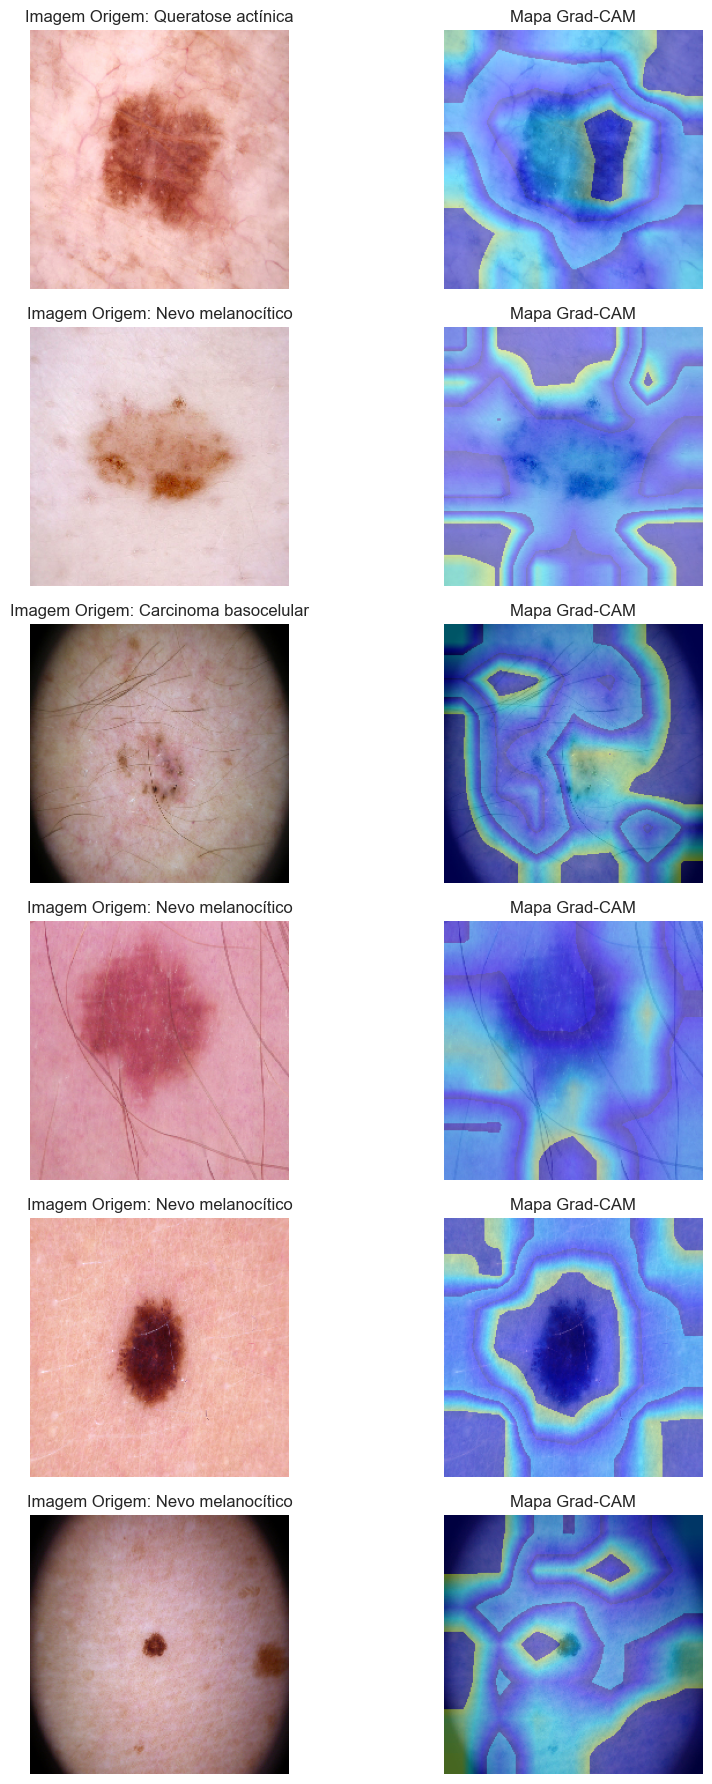

In [ ]:
gradcam_em_lote(model, test_df, ultima_conv, num_imagens=6)

### 💾 Salvamento do Modelo (formato moderno .keras)

In [ ]:
# ------------------------------------------------------------------
# Gerando o modelo do KERAS
# ------------------------------------------------------------------
model.save('modelo_cancer_pele.keras')
print('Modelo gerado com sucesso!')

Modelo gerado com sucesso!
